In [9]:
%%time
# Standard library imports
import os

# Third-party imports
import tifffile
import matplotlib.pyplot as plt
import numpy as np

# ClearEx library imports
from clearex.registration import ChunkedImageRegistration
from tests import download_test_registration_data


CPU times: user 15 μs, sys: 1e+03 ns, total: 16 μs
Wall time: 18.8 μs


In [3]:
%%time
output_path = download_test_registration_data()

# Define file paths for fixed and moving images
fixed_path = os.path.join(
    output_path,
    "cropped_fixed.tif")

moving_path = os.path.join(
    output_path,
    "cropped_moving.tif")

transform_path = os.path.join(
    output_path,
    "GenericAffine.mat")

transform_list = [transform_path]


Test data already exists at /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data. Skipping download.
CPU times: user 0 ns, sys: 915 μs, total: 915 μs
Wall time: 2.34 ms


In [4]:
%%time
# Create a ChunkedImageRegistration instance
registrar = ChunkedImageRegistration(
    fixed_image_path=fixed_path,
    moving_image_path=moving_path,
    save_directory=output_path,
    imaging_round=1,
    crop=False,
    enable_logging=True
)

# Set chunk parameters (optional - defaults are already set)
registrar.chunk_size = (128, 128, 128)  # Adjust based on your data size
registrar.overlap_fraction = 0.15

print(f"Fixed image shape: {registrar.fixed_image_info.shape}")
print(f"Moving image shape: {registrar.moving_image_info.shape}")
print(f"Number of chunks: {len(registrar.chunk_info_list)}")


2025-11-25 07:20:42,912 - INFO - Image registration performed with antspyx: 0.6.1
2025-11-25 07:20:42,913 - INFO - Opening /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/cropped_fixed.tif
2025-11-25 07:20:42,913 - INFO - Using reader: TiffReader.
2025-11-25 07:20:42,971 - INFO - Loaded cropped_fixed.tif as NumPy array.
2025-11-25 07:20:42,972 - INFO - Opening /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/cropped_moving.tif
2025-11-25 07:20:42,972 - INFO - Using reader: TiffReader.
2025-11-25 07:20:43,027 - INFO - Loaded cropped_moving.tif as NumPy array.
2025-11-25 07:20:43,028 - INFO - Loaded fixed image /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/cropped_fixed.tif. Shape: (925, 163, 306).
2025-11-25 07:20:43,029 - INFO - Loaded moving image /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/cropped_moving.tif. Shape: (925, 163, 306).
2025-11-

In [5]:
%%time
# Perform the full registration (linear + chunked nonlinear)
registrar.register()

print("\nRegistration complete!")
print(f"Output directory: {output_path}")


2025-11-25 07:20:50,850 - INFO - Linear transformation already exists at /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/linear_transform_1.mat. Skipping registration.
2025-11-25 07:20:52,013 - INFO - Beginning Chunked Nonlinear Registration...
2025-11-25 07:20:52,054 - INFO - Chunk 1/10
2025-11-25 07:20:52,054 - INFO - Processing chunk 0...
2025-11-25 07:20:52,509 - INFO -   Performing fine nonlinear registration...
2025-11-25 07:23:47,408 - INFO -   Local transform saved: /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/chunks/chunk_0000_warp.nii.gz
2025-11-25 07:23:49,526 - INFO - Chunk 2/10
2025-11-25 07:23:49,526 - INFO - Processing chunk 1...
2025-11-25 07:23:49,877 - INFO -   Performing fine nonlinear registration...
2025-11-25 07:24:56,415 - INFO -   Local transform saved: /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/chunks/chunk_0001_warp.nii.gz
2025-11-25 07:24:57,205 - 

Exception: Only ANTsTransform instances can be written to file. Check that you are not passing in a filepath to a saved transform.

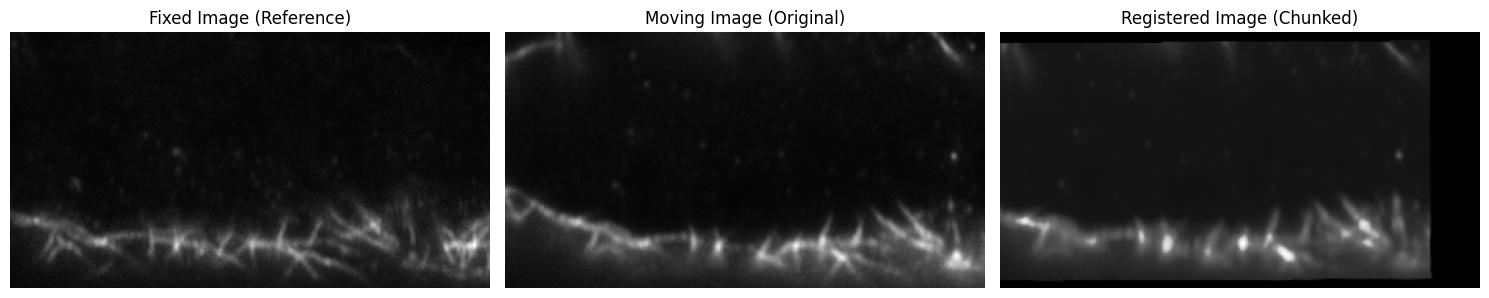

CPU times: user 290 ms, sys: 88.6 ms, total: 378 ms
Wall time: 560 ms


In [6]:
%%time
# Load and visualize results
registered_image = tifffile.imread(
    os.path.join(output_path, "nonlinear_registered_1.tif")
)

# Display middle slices
z_mid = registered_image.shape[0] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Fixed image
fixed_img = tifffile.imread(fixed_path)
axes[0].imshow(fixed_img[z_mid], cmap='gray')
axes[0].set_title('Fixed Image (Reference)')
axes[0].axis('off')

# Moving image (original)
moving_img = tifffile.imread(moving_path)
axes[1].imshow(moving_img[z_mid], cmap='gray')
axes[1].set_title('Moving Image (Original)')
axes[1].axis('off')

# Registered image
axes[2].imshow(registered_image[z_mid], cmap='gray')
axes[2].set_title('Registered Image (Chunked)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


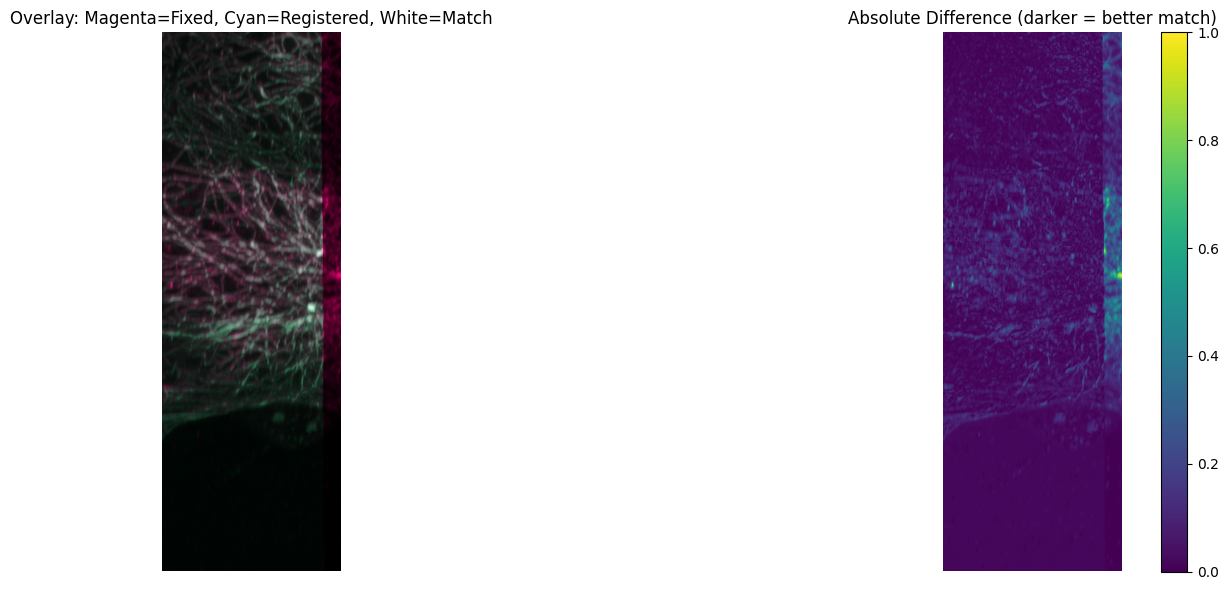

Mean absolute difference: 0.050889
Max absolute difference: 1.000000
CPU times: user 237 ms, sys: 20.8 ms, total: 258 ms
Wall time: 258 ms


In [11]:
%%time
# Create colorblind-friendly overlay to visualize registration quality
# Using magenta (fixed) and cyan (registered) which are distinguishable for colorblind viewers

# Normalize images to 0-1 range for visualization
def normalize_image(img):
    img_min, img_max = img.min(), img.max()
    if img_max > img_min:
        return (img - img_min) / (img_max - img_min)
    return img

fixed_norm = normalize_image(np.max(fixed_img, axis=1))
registered_norm = normalize_image(np.max(registered_image, axis=1))

# Create RGB overlay
# Magenta = Red + Blue, Cyan = Green + Blue
# Where images match, you'll see white/gray
# Where they differ: magenta shows fixed, cyan shows registered
overlay = np.zeros((*fixed_norm.shape, 3))
overlay[:, :, 0] = fixed_norm          # Red channel: fixed image
overlay[:, :, 1] = registered_norm      # Green channel: registered image
overlay[:, :, 2] = (fixed_norm + registered_norm) / 2  # Blue channel: average

# Also create a difference map
difference = np.abs(fixed_norm - registered_norm)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Overlay visualization
axes[0].imshow(overlay)
axes[0].set_title('Overlay: Magenta=Fixed, Cyan=Registered, White=Match')
axes[0].axis('off')

# Difference map
im = axes[1].imshow(difference, cmap='viridis')  # viridis is colorblind-friendly
axes[1].set_title('Absolute Difference (darker = better match)')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Mean absolute difference: {difference.mean():.6f}")
print(f"Max absolute difference: {difference.max():.6f}")
